In [1]:
# Import useful modules
import glob
import os
import os.path as op
import sys
import csv
import numpy as np
import pandas as pd
import time
import random as rand
import itertools
import copy
import utils

from os import chdir

from scipy import io as sio

import nibabel as nib
from nilearn.masking import compute_epi_mask
from nilearn.masking import apply_mask
from nilearn.input_data import MultiNiftiMasker

from sklearn.metrics import r2_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression

from nilearn import plotting
from nilearn.image import math_img, mean_img, threshold_img
from nilearn.plotting import plot_glass_brain
from nilearn.plotting import plot_anat
from nilearn.plotting import view_img
from nilearn.image import coord_transform
from nistats.design_matrix import make_first_level_design_matrix
from nistats import datasets
from nistats.reporting import plot_design_matrix


import neural_proba_filepath
from neural_proba_filepath import import_distrib_param
from neural_proba_filepath import distrib
from neural_proba_filepath import tuning_curve
from neural_proba_filepath import voxel
from neural_proba_filepath import experiment
from neural_proba_filepath import fmri

import matplotlib.pyplot as plt
from matplotlib import rc


%matplotlib inline

/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/tb258044/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Experimental settings

In [3]:
## Compute X for each subject from ideal observer model output 

# Define the seed to reproduce results from random processes
rand.seed(4);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc', 'rate']
n_schemes = len(scheme_array)

N_array = np.array([2, 3, 4, 5, 6, 7, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.12, 0.1, 8e-2, 7e-2, 6e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.2, 0.15, 0.12, 0.10, 9e-2, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Number of tuning curves that will be used for each scheme (results from simulation 1)
optimal_k_fit_N_array = np.array([3, 0, 2, 0, 1]).astype(int)

optimal_fit_N_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_mu_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)
optimal_t_conf_array = np.zeros_like(optimal_k_fit_N_array).astype(float)

for k_fit_scheme in range(n_schemes-1):    # We exclude rate coding
    optimal_fit_N_array[k_fit_scheme] = N_array[optimal_k_fit_N_array[k_fit_scheme]]    # Optimal N
    # Now we fill values for optimal mu and t
    if k_fit_scheme % 2 == 0:    # Gaussian case
        t_mu_tmp = t_mu_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        t_conf_tmp = t_conf_gaussian_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_mu_array[k_fit_scheme] = t_mu_tmp
        optimal_t_conf_array[k_fit_scheme] = t_conf_tmp
    else:  # Sigmoid case
        optimal_t_mu_array[k_fit_scheme] = t_mu_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]
        optimal_t_conf_array[k_fit_scheme] = t_conf_sigmoid_array[optimal_k_fit_N_array[k_fit_scheme]]
# Assume there is one response curve in the rate coding case
optimal_fit_N_array[4] = 1 
        
# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# Rate coding scaling parameters between probability and confidence neurons
mu_sd = 0.219    # Std of the signal of mu's
conf_sd = 0.284    # Std of the signal of conf's

# The number of possible N
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 20

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)
between_population_sparsity_array = np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]])

# The number of subjects
n_subjects = 1000

# Create the matrix with all the possibilities (mu or 1-mu encoded in each session) of size 16x4
directions = np.array(list(itertools.product([0,1], repeat=4)))
n_directions = len(directions)

# The number of sessions
n_sessions = 4

# Experimental options
n_stimuli = 380    # The number of stimuli per session
between_stimuli_duration = 1.3
min_break_time = 8
max_break_time = 12
min_n_local_regular_stimuli = 12
max_n_local_regular_stimuli = 18

# Transition proba or Bernoulli proba
distrib_type = 'transition' # transition or bernoulli

# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

In [4]:
def get_experiment_info(rootdir, k_subject):
    ''' Load the experiment information (onsets, durations, motions) and set conditions and frametimes 
    for design matrix creation''' 
    
    experiment_path = rootdir
    
    # Quantities to load and define 
    n_scans = [None for k_session in range(n_sessions)]
    onsets = [None for k_session in range(n_sessions)] 
    durations = [None for k_session in range(n_sessions)] 
    motion = [None for k_session in range(n_sessions)]  
    conditions = [None for k_session in range(n_sessions)] 
    frame_times = [None for k_session in range(n_sessions)] 

    # Import information about the slice timing 
    slice_timing_filepath = os.path.join(experiment_path,
                                "MRI_data/analyzed_data/",
                                "subj%02d/" % k_subject,
                                "preprocEPI/SliceTimingInfo.mat")
    slice_timing = sio.loadmat(slice_timing_filepath)
    t_r = slice_timing['TR'] # TR will be used for defining frame times 
    
    # Define SPM filepath 
    spm_filepath = os.path.join(experiment_path,
                                     "MRI_data/analyzed_data/",
                                     "subj%02d" % k_subject,
                                     "first_level_estimates/Model01_QualityCheck/SPM.mat") 
    
    for k_session in range(n_sessions):
        # Import the number of scans from MATLAB file 
        n_scans[k_session] = sio.loadmat(spm_filepath)['SPM']['nscan'][0][0][0][k_session]
        
        # Define frame times from no. scans and TR
        frame_times[k_session] = (np.arange(n_scans[k_session]) * t_r).flatten()
        
        ## Import the onsets and durations from MATLAB file 
        experiment_filepath = glob.glob(os.path.join(experiment_path,
                                                    "MRI_data/analyzed_data/",
                                                    "subj%02d/" % k_subject,
                                                    "MultiCond",
                                                    "Model1_QualityCheck_multicond*session%01d.mat" 
                                                     % int(k_session+1)))
        data_mat = sio.loadmat(experiment_filepath[0])
        # Load the onsets 
        onsets[k_session] = data_mat['onsets'][0][0].flatten()
        # Load the durations
        
        durations[k_session] =[(data_mat['durations'][0][0][0][0]) for i in range(onsets[k_session].size)]
    
        # Load motion information 
        motion_filepath = glob.glob(os.path.join(experiment_path,
                                                 "MRI_data/analyzed_data/",
                                                 "subj%02d" % k_subject,
                                                 "preprocEPI",
                                                 "rp_aepi_sess%01d*.txt" % int(k_session+1)))
        numconv = lambda x : str.replace(x.decode('utf-8'), 'D', 'E') # used for importing motion files
        motion[k_session] = np.loadtxt(motion_filepath[0], converters={
            0:numconv, 1:numconv, 2:numconv, 3:numconv, 4:numconv, 5:numconv})
        
        # Define conditions for design matrix creation
        conditions[k_session] = ['stim' for k in range(onsets[k_session].size)]
        
    return n_scans, frame_times, onsets, durations, motion, conditions

In [5]:
def get_ideal_observer_data(k_subject):
    
    p1_dist_array = [None for k_session in range(n_sessions)]
    p1_mu_array = [None for k_session in range(n_sessions)]
    p1_sd_array = [None for k_session in range(n_sessions)]
    
    for k_session in range(n_sessions):
        # Load the corresponding data
        if distrib_type == 'transition':
            filepath = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/MRI_ANALYSIS/IdealObserverData/Subject_'+str(k_subject).zfill(2)+'_MRIsession_'+str(k_session+1)+'_IOMarkov.mat'
        if distrib_type == 'bernoulli':
            filepath = '/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/MRI_ANALYSIS/IdealObserverData/Subject_'+str(k_subject).zfill(2)+'_MRIsession_'+str(k_session+1)+'_IOBernoulli.mat'

        [p1_dist_array[k_session], p1_mu_array[k_session], p1_sd_array[k_session]] = neural_proba_filepath.import_distrib_param(filepath, n_subjects, n_sessions, n_stimuli, distrib_type)
    
    return [p1_dist_array, p1_mu_array, p1_sd_array]

In [6]:
def compute_tc_activity(k_subject):
    '''Computes the activity of each tuning curve, for each scheme, each direction and each session'''
    
    # Import ideal observer data 
    [p1_dist_array, p1_mu_array, p1_sd_array] = get_ideal_observer_data(k_subject)
    
    # Quantities that will be computed 
    tc_signal_mu = [[[[None for k_tc in range(int(optimal_fit_N_array[k_fit_scheme]))] for k_session in range(n_sessions)]
                     for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes)]
    tc_signal_conf = [[[[None for k_tc in range(int(optimal_fit_N_array[k_fit_scheme]))] for k_session in range(n_sessions)]
                       for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes)]

    tc_activity_mu = [[[[None for k_tc in range(int(optimal_fit_N_array[k_fit_scheme]))] for k_session in range(n_sessions)]
                     for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes)]
    tc_activity_conf = [[[[None for k_tc in range(int(optimal_fit_N_array[k_fit_scheme]))] for k_session in range(n_sessions)]
                       for k_direction in range(n_directions)] for k_fit_scheme in range(n_schemes)]

    for k_fit_scheme in range(n_schemes):
        fit_scheme = scheme_array[k_fit_scheme]
        fit_N = int(optimal_fit_N_array[k_fit_scheme])
        ### Loop over the directions
        for k_direction in range(n_directions):
            ### Loop over the sessions : we start with it in order to have the same length whatever N_fit is
            for k_session in range(n_sessions):
                if directions[k_direction, k_session] == 0:
                    mu = p1_mu_array[k_session][:n_stimuli].flatten()
                    dist = p1_dist_array[k_session][:, :n_stimuli]
                else:
                    mu = (1 - (p1_mu_array[k_session][:n_stimuli])).flatten()
                    dist = np.flipud(p1_dist_array[k_session][:, :n_stimuli])
                dist = [distrib(0.5,0.5,dist[:,k]) for k in range(n_stimuli)] # to get the right format for projection computation
                sigma = p1_sd_array[k_session][:n_stimuli].flatten()
                conf = -np.log(sigma)

                for k_tc in range(fit_N):
                    if k_fit_scheme < 4:
                        fit_t_mu = optimal_t_mu_array[k_fit_scheme]
                        fit_t_conf = optimal_t_conf_array[k_fit_scheme]
                        if fit_scheme.find('gaussian') != -1:
                            fit_tc_type = 'gaussian'

                        if fit_scheme.find('sigmoid') != -1:
                            fit_tc_type = 'sigmoid'

                        # Create the tuning curve objects
                        fit_tc_mu = tuning_curve(fit_tc_type, fit_N, fit_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
                        fit_tc_conf = tuning_curve(fit_tc_type, fit_N, fit_t_conf, tc_lower_bound_conf, tc_upper_bound_conf)

                    if fit_scheme.find('ppc') != -1: # PPC case
                        tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc] =  fit_tc_mu.f(mu, k_tc)
                        tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc] = fit_tc_conf.f(conf, k_tc)
                    elif fit_scheme.find('dpc') != -1: # DPC case, with projection computation
                        tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc] =  fit_tc_mu.compute_projection(
                            dist, k_tc, False)
                        tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc] = (np.arange(n_stimuli)*0) # dummy variable
                    elif fit_scheme.find('rate') != -1: # Rate case
                        tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc] = mu
                        tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc] = conf


    return tc_signal_mu, tc_signal_conf

In [10]:
def compute_design_matrices(k_subject):
    '''TODO: store each subject design matrices in one ndarray'''
    
    # Import experimental settings 
    n_scans, frame_times, onsets, durations, motion, conditions = get_experiment_info(rootdir, k_subject)
    # Import tc activities
    tc_signal_mu, tc_signal_conf = compute_tc_activity(k_subject)
    
    #n_matrices = np.array([2, 2, 1, 1, 2]).astype(int)
    #X = [[[None for k_matrix in range(n_matrices[k_fit_scheme])] for k_direction in range(n_directions)]
    #     for k_fit_scheme in range(n_schemes)]
    
    ### Loop over the schemes
    for k_fit_scheme in range(n_schemes):
        fit_scheme = scheme_array[k_fit_scheme]
        fit_N = int(optimal_fit_N_array[k_fit_scheme])
        ### Loop over the directions
        for k_direction in range(n_directions):
            ## Loop over the sessions    
            for k_session in range(n_sessions):
                if fit_scheme.find('dpc') != -1:
                    tc_mu = np.zeros((int(n_scans[k_session]), fit_N))
                else:
                    tc_mu = np.zeros((int(n_scans[k_session]), fit_N))
                    tc_conf = np.zeros((int(n_scans[k_session]), fit_N))
                for k_tc in range(fit_N):
                    if fit_scheme.find('dpc') != -1:
                        p_mod = tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc]
                        events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                               'trial_type': conditions[k_session], 'modulation': p_mod})
                        X = make_first_level_design_matrix(frame_times[k_session], events, hrf_model='spm')
                        tc_mu[:, k_tc] = np.array(X['stim'])

                    else:
                        # get regressors for mu
                        p_mod_mu = tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc]
                        events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                               'trial_type': conditions[k_session], 'modulation': p_mod_mu})
                        X_mu = make_first_level_design_matrix(frame_times[k_session], events, hrf_model='spm')
                        # keep only our regressor or interest for mu
                        tc_mu[:, k_tc] = np.array(X_mu['stim'])

                        # get regressors for conf
                        p_mod_conf = tc_signal_conf[k_fit_scheme][k_direction][k_session][k_tc]
                        events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                               'trial_type': conditions[k_session], 'modulation': p_mod_conf})
                        X_conf = make_first_level_design_matrix(frame_times[k_session], events, hrf_model='spm')

                        # keep only our regressor of interest for confidence
                        tc_conf[:, k_tc] = np.array(X_conf['stim'])


                ## Get the design matrix for each session and each direction with 4 concatenated-sessions
                # Redefine events to create our final design matrix 
                events = pd.DataFrame({'onset': onsets[k_session], 'duration': durations[k_session],
                                       'trial_type': conditions[k_session]})

                # Concatenate the tuning curves and motion movements to include in the model regressors
                add_regs_mu = np.hstack((tc_mu, motion[k_session]))
                if fit_scheme.find('ppc') != -1 or fit_scheme.find('rate')!= -1: # add only for ppc and rate cases
                    add_regs_conf = np.hstack((tc_conf, motion[k_session]))

                # Define the names of the regressors
                add_reg_names_mu = [f"TC{k+1}_mu" for k in range(fit_N)]
                if fit_scheme.find('ppc')!= -1 or fit_scheme.find('rate') != -1: # add only for ppc and rate cases
                    add_reg_names_conf = [f"TC{k+1}_conf" for k in range(fit_N)]

                for k in range(motion[k_session].shape[1]):
                    add_reg_names_mu.append(f"mvt{k+1}")
                    if fit_scheme.find('ppc')!= -1 or fit_scheme.find('rate') != -1:
                        add_reg_names_conf.append(f"mvk{k+1}")
                        
                # Compute the design matrix in all cases (corresponds to mu in ppc and rate cases)
                design_matrix = make_first_level_design_matrix(frame_times[k_session], events, drift_model=None, 
                                                               period_cut=128, add_regs=add_regs_mu, add_reg_names=add_reg_names_mu, hrf_model='spm')
                design_matrix['session1'], design_matrix['session2'], design_matrix['session3'], design_matrix['session4'] = [0, 0, 0, 0]
                design_matrix[f"session{k_session+1}"] = 1 # add a column for the session (=1 for the current session)
                design_matrix = design_matrix.drop(columns="constant") # remove "constant" column
                if k_session == 0:
                    design_mat_final = design_matrix
                else:
                    # concatenate sessions vertically 
                    design_mat_final = pd.concat([design_mat_final, design_matrix])
                    
                # Compute the design matrix for conf only n the PPC and rate cases 
                if fit_scheme.find('ppc')!= -1 or fit_scheme.find('rate') != -1:
                    design_matrix_conf = make_first_level_design_matrix(frame_times[k_session], events, drift_model=None, period_cut=128,
                                                                        add_regs=add_regs_conf, add_reg_names=add_reg_names_conf, hrf_model='spm')
                    design_matrix_conf['session1'], design_matrix_conf['session2'], design_matrix_conf['session3'], design_matrix_conf['session4'] = [0, 0, 0, 0]
                    design_matrix_conf[f"session{k_session+1}"] = 1 # add a column for the session (=1 for the current session)
                    design_matrix_conf = design_matrix_conf.drop(columns="constant") # remove "constant" column 
                    if k_session == 0:
                        design_mat_conf_final = design_matrix_conf
                    else:
                        design_mat_conf_final = pd.concat([design_mat_conf_final, design_matrix_conf])
            
            # Save design matrices under the pickle format so that we can reopen the pandas DataFrame
            if fit_scheme.find('dpc') != -1: # DPC case
                design_mat_final.to_pickle('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/design_matrices/subj'+str(k_subject).zfill(2)+'/dmtx_'+str(fit_scheme)+'_dir'+str(k_direction).zfill(2)+'.pkl')
            else: # PPC and rate cases
                design_mat_final.to_pickle('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/design_matrices/subj'+str(k_subject).zfill(2)+'/dmtx_'+str(fit_scheme)+'_mu_dir'+str(k_direction).zfill(2)+'.pkl')
                design_mat_conf_final.to_pickle('/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/ENCODAGE/design_matrices/subj'+str(k_subject).zfill(2)+'/dmtx_'+str(fit_scheme)+'_conf_dir'+str(k_direction).zfill(2)+'.pkl')

        print(f'scheme: {k_fit_scheme} done!')
    
    #return X

In [11]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
rootdir = "/neurospin/unicog/protocols/IRMf/Meyniel_MarkovGuess_2014/"
for sub in subjects:
    start = time.time()
    print(f'Creating design matrices for subject {sub:02d}...')
    compute_design_matrices(sub)
    end = time.time()
    print(f'Subject {sub:02d} done in {end-start} seconds.')

Creating design matrices for subject 01...


/home/tb258044/.local/lib/python3.7/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/tb258044/.local/lib/python3.7/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/tb258044/.local/lib/python3.7/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


scheme: 0 done!


/home/tb258044/.local/lib/python3.7/site-packages/nistats/utils.py:262: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


scheme: 1 done!
scheme: 2 done!
scheme: 3 done!
scheme: 4 done!
Subject 01 done in 35.593204975128174 seconds.
Creating design matrices for subject 02...
scheme: 0 done!
scheme: 1 done!
scheme: 2 done!
scheme: 3 done!
scheme: 4 done!
Subject 02 done in 38.60107493400574 seconds.
Creating design matrices for subject 03...
scheme: 0 done!
scheme: 1 done!
scheme: 2 done!
scheme: 3 done!
scheme: 4 done!
Subject 03 done in 36.743096351623535 seconds.
Creating design matrices for subject 04...
scheme: 0 done!
scheme: 1 done!
scheme: 2 done!
scheme: 3 done!
scheme: 4 done!
Subject 04 done in 38.60965442657471 seconds.
Creating design matrices for subject 05...
scheme: 0 done!
scheme: 1 done!
scheme: 2 done!
scheme: 3 done!
scheme: 4 done!
Subject 05 done in 37.94994521141052 seconds.
Creating design matrices for subject 06...
scheme: 0 done!
scheme: 1 done!
scheme: 2 done!
scheme: 3 done!
scheme: 4 done!
Subject 06 done in 38.411754846572876 seconds.
Creating design matrices for subject 07...

## Sanity checks

### Plot tuning curve responses

Text(0.5, 1.0, 'rate: TC n°0 activation - conf')

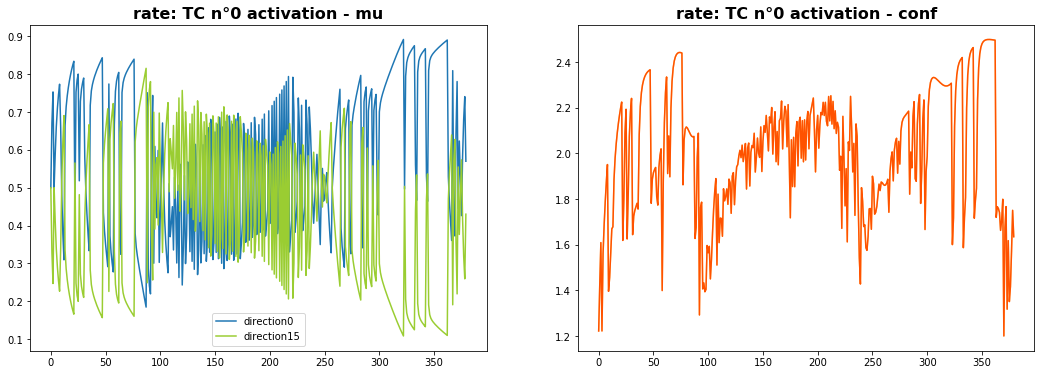

In [39]:
k_fit_scheme = 4
fit_scheme = scheme_array[k_fit_scheme]
k_direction = 0
k_direction_inv = 15
k_session = 0
k_tc = 0

fig = plt.figure(figsize=[18,6])
ax1 = fig.add_subplot(121)
plt.plot(tc_signal_mu[k_fit_scheme][k_direction][k_session][k_tc], label='direction0')
plt.plot(tc_signal_mu[k_fit_scheme][k_direction_inv][k_session][k_tc], color='yellowgreen', label='direction15')
plt.legend()
plt.title(f"{fit_scheme}: TC n°{k_tc} activation - mu", size=16, fontweight='bold')

ax2 = fig.add_subplot(122)
plt.plot(tc_signal_conf[k_fit_scheme][0][k_session][k_tc], color='orange')
plt.plot(tc_signal_conf[k_fit_scheme][15][k_session][k_tc], color='red', alpha=0.5)
plt.title(f"{fit_scheme}: TC n°{k_tc} activation - conf", size=16, fontweight='bold')

### Plot design matrices

In [52]:
gaussian_ppc_mu = pd.read_pickle("DesignMatrices/design_mat_mu_gaussian_ppc_dir0.pkl") # load matrix 

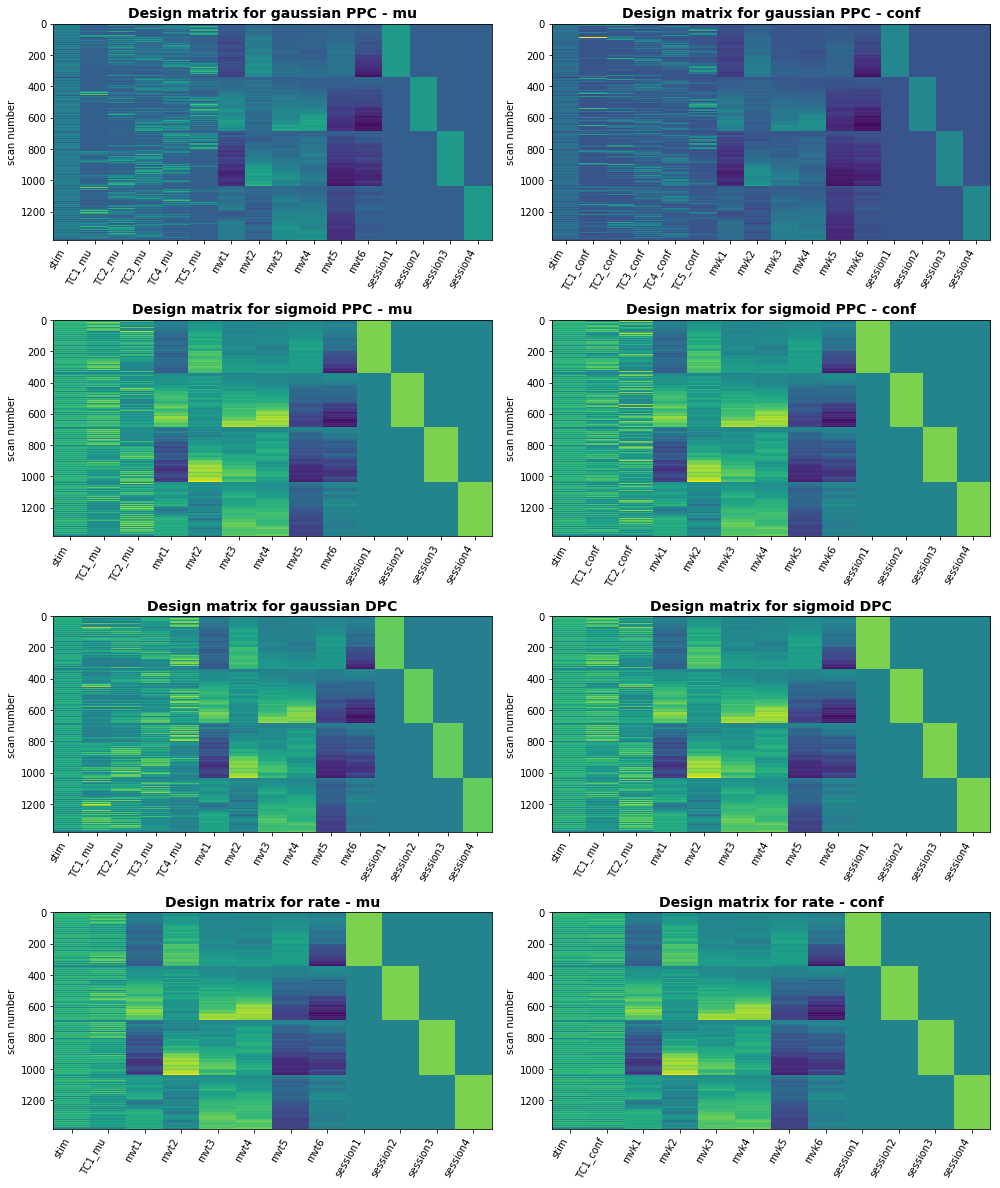

In [3]:
fig = plt.figure(figsize=[14,20])

ax1 = fig.add_subplot(521)
gaussian_ppc_mu = pd.read_pickle("DesignMatrices/subj01/dmtx_gaussian_ppc_mu_dir00.pkl") # load matrix 
plot_design_matrix(gaussian_ppc_mu, ax=ax1)
plt.title('Design matrix for gaussian PPC - mu', fontweight='bold', fontsize=14)
ax2 = fig.add_subplot(522)
gaussian_ppc_conf = pd.read_pickle("DesignMatrices/subj01/dmtx_gaussian_ppc_conf_dir00.pkl")
plot_design_matrix(gaussian_ppc_conf, ax=ax2)
plt.title('Design matrix for gaussian PPC - conf', fontweight='bold', fontsize=14)

ax3 = fig.add_subplot(523)
sigmoid_ppc_mu = pd.read_pickle("DesignMatrices/subj01/dmtx_sigmoid_ppc_mu_dir00.pkl")
plot_design_matrix(sigmoid_ppc_mu, ax=ax3)
plt.title('Design matrix for sigmoid PPC - mu', fontweight='bold', fontsize=14)
ax4 = fig.add_subplot(524)
sigmoid_ppc_conf = pd.read_pickle("DesignMatrices/subj01/dmtx_sigmoid_ppc_conf_dir00.pkl")
plot_design_matrix(sigmoid_ppc_conf, ax=ax4)
plt.title('Design matrix for sigmoid PPC - conf', fontweight='bold', fontsize=14)

ax5 = fig.add_subplot(525)
gaussian_dpc = pd.read_pickle("DesignMatrices/subj01/dmtx_gaussian_dpc_dir00.pkl")
plot_design_matrix(gaussian_dpc, ax=ax5)
plt.title('Design matrix for gaussian DPC', fontweight='bold', fontsize=14)
ax6 = fig.add_subplot(526)
sigmoid_dpc = pd.read_pickle("DesignMatrices/subj01/dmtx_sigmoid_dpc_dir00.pkl")
plot_design_matrix(sigmoid_dpc, ax=ax6)
plt.title('Design matrix for sigmoid DPC', fontweight='bold', fontsize=14)

ax7 = fig.add_subplot(527)
rate_mu = pd.read_pickle("DesignMatrices/subj01/dmtx_rate_mu_dir00.pkl")
plot_design_matrix(rate_mu, ax=ax7)
plt.title('Design matrix for rate - mu', fontweight='bold', fontsize=14)
ax8 = fig.add_subplot(528)
rate_conf = pd.read_pickle("DesignMatrices/subj01/dmtx_rate_conf_dir00.pkl")
plot_design_matrix(rate_conf, ax=ax8)
plt.title('Design matrix for rate - conf', fontweight='bold', fontsize=14)

plt.show()

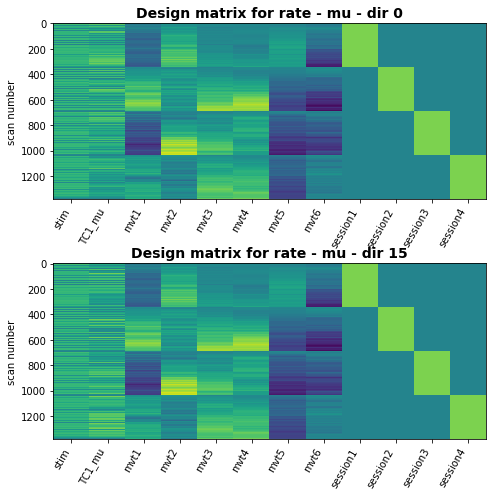

In [13]:
rate_mu_2 = pd.read_pickle("DesignMatrices/subj01/dmtx_rate_mu_dir15.pkl")

fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(211)
plot_design_matrix(rate_mu, ax=ax)
plt.title('Design matrix for rate - mu - dir 0', fontweight='bold', fontsize=14)
ax2 = fig.add_subplot(212)
plot_design_matrix(rate_mu_2, ax = ax2)
plt.title('Design matrix for rate - mu - dir 15', fontweight='bold', fontsize=14)
plt.show()